# Plot LFRic Data at Differing Resolutions 

In this exercise you will plot example data from a LFRic model at C48 resolution using the cartopy python package. 

The aim of the exercise is to explore plotting routines for plotting cube sphered data. 

The data provided is only a small subset of the large amount of diagnostics it is possible to get out of the model. 

Feel free to plot using other projections: 
https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import netCDF4 as nc  # noqa: N813
import numpy as np
from matplotlib.collections import PolyCollection
from shapely.geometry import GeometryCollection, LineString, Polygon, box
from shapely.ops import split


In [2]:
import warnings

# ignores some chatty cartopy warnings about missing projection information.
warnings.filterwarnings("ignore", message="Approximating coordinate system")

In [3]:
# Select one of the variable below (uncomment the one you want)
variable = "qv"  # specific humidity
# variable = "co"  # carbon monoxide
# variable = "no"  # nitric oxide
# variable = "o3"  # ozone

level = 1

datadir="/home/vagrant/Tutorials/UMvn13.9/data/Task17/"

# diagnostic output from a C48 lfric model
dataset = nc.Dataset(datadir+"lfric_diagnostics_subset.nc")

In [4]:
def get_cmap(variable: str) -> tuple[str, float]:
    """Get cmap for plotting with valid cmax."""
    match variable:
        case "qv":
            return "terrain_r", 2e-2
        case "co":
            return "viridis", 0.5e-6
        case "no":
            return "hot_r", 0.8e-8
        case "o3":
            return "CMRmap", 1.2e-7

    return "viridis"

In [5]:
cmap, vmax = get_cmap(variable)

In [6]:
def lfric_face_coords(dataset: nc.Dataset) -> GeometryCollection:
    """
    From a output dataset construction a geometry collection of each face of
    the mesh's grid.

    Args:
        dataset (nc.Dataset): loaded in diagnostics netcdf.

    Returns:
        GeometryCollection: collection of polygon objects, one for each face
        of the mesh.

    """
    lons = np.asarray(dataset.variables["Mesh2d_node_x"][:])
    lats = np.asarray(dataset.variables["Mesh2d_node_y"][:])
    face_nodes = np.asarray(dataset.variables["Mesh2d_face_nodes"][:, :])

    try:
        start_index = dataset.variables["Mesh2d_face_nodes"].getncattr(
            "start_index")
    except AttributeError:
        start_index = 0

    face_nodes -= start_index
    coords = np.stack((lons[face_nodes], lats[face_nodes]), axis=-1)
    return coords, lons, lats


In [7]:
def get_lfric_diag(dataset: nc.Dataset, var_label: str, level: int = 0,
                   ) -> tuple[np.ndarray, str, str]:
    """
    Get variable data, name and units from a lfric diag nc.Dataset object.

    Args:
        dataset (nc.Dataset): loaded in lfric diagnostic dataset.
        var_label (str): the variable name, e.g. theta for air potential
            temperature.
        level (int, optional): the vertical level index. Defaults to 0.

    Returns:
        tuple[np.ndarray, str]: tuple of data, name and units. Name will
            default to var_label if long_name attribute not present. Units
            will default to unknown if units attribute not present.

    """
    variable = dataset.variables[var_label]
    dims = [dim.name for dim in variable.get_dims()]
    if "full_levels" in dims:
        variable_data = np.asarray(variable[0, level, :].squeeze())
    else:
        variable_data = np.asarray(variable[0, :].squeeze())

    try:
        name = variable.getncattr("long_name")
    except AttributeError:
        name = var_label

    try:
        units = variable.getncattr("units")
    except AttributeError:
        units = "unknown"

    return variable_data, name, units


In [8]:
# construct a list of coordinates for each face from the dataset
coords, lons, lats = lfric_face_coords(dataset)
# extract the data as a numpy array
data, name, units = get_lfric_diag(dataset, variable, level=level)

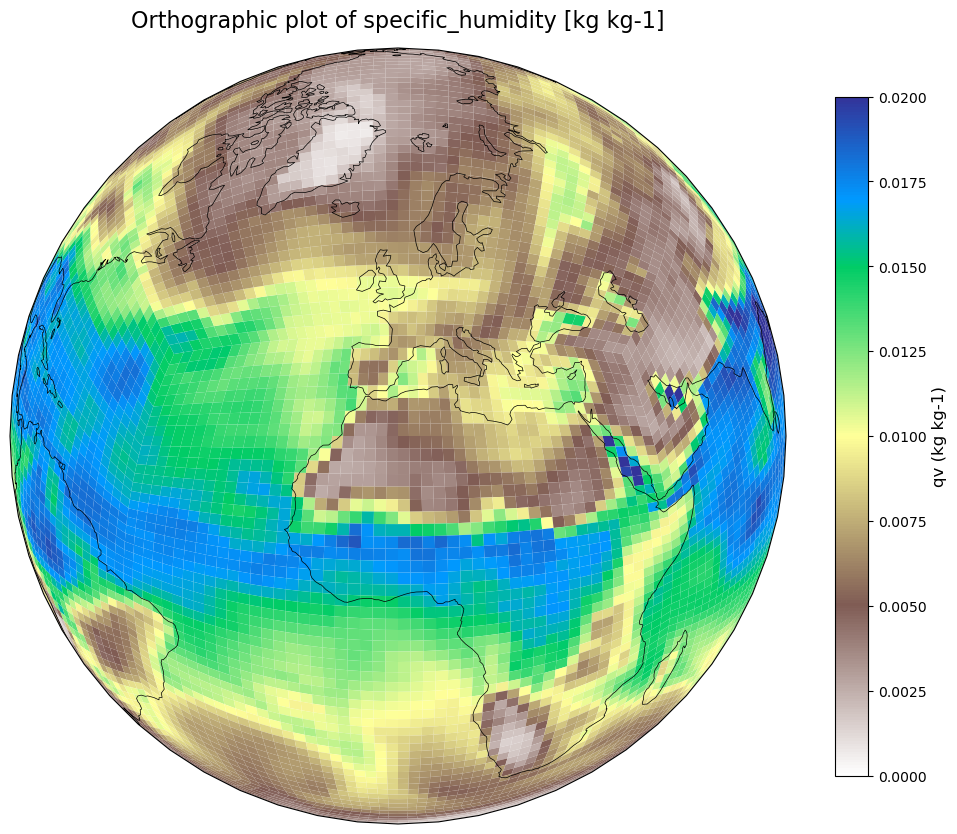

In [9]:
fig = plt.figure(figsize=(10, 10))
proj = ccrs.Orthographic(central_longitude=0, central_latitude=30)
ax = plt.axes(projection=proj)

# using a polycollection for quickly plotting a large number of polygons
poly = PolyCollection(
    coords,
    array=data,
    cmap=cmap,
    edgecolors="none",
    transform=ccrs.Geodetic(),
    clim=[0.0, vmax],
)

ax.add_collection(poly)
ax.coastlines(linewidth=0.5)
ax.set_global()

title = f"Orthographic plot of {name} [{units}]"
plt.title(title, fontsize=16, pad=15)

cbar = plt.colorbar(poly, ax=ax, shrink=0.7)
cbar.set_label(f"{variable} ({units})", fontsize=12)

plt.tight_layout()
plt.show()

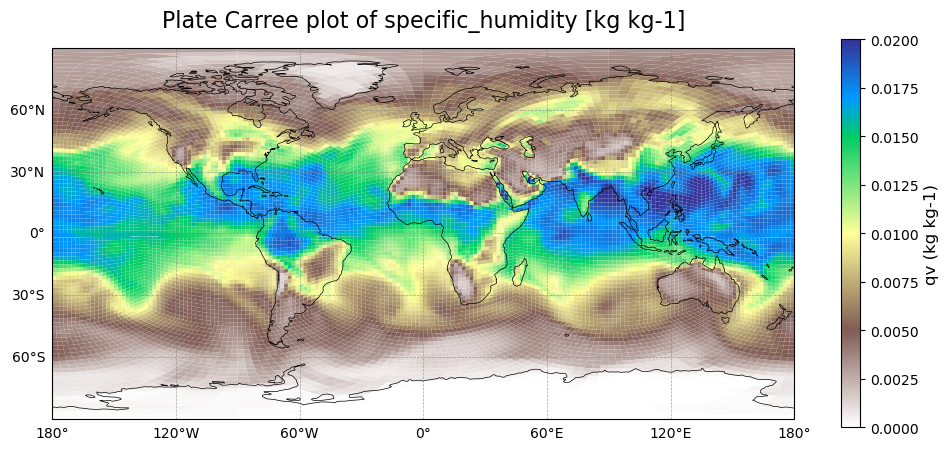

In [10]:
fig = plt.figure(figsize=(10, 10))
proj = ccrs.PlateCarree(central_longitude=0)
ax = plt.axes(projection=proj)

# using a polycollection for quickly plotting a large number of polygons
poly = PolyCollection(
    coords,
    array=data,
    cmap=cmap,
    edgecolors="none",
    transform=ccrs.Geodetic(),
    clim=[0.0, vmax],
)

ax.add_collection(poly)
ax.coastlines(linewidth=0.5)
ax.set_global()

title = f"Plate Carree plot of {name} [{units}]"
plt.title(title, fontsize=16, pad=15)

cbar = plt.colorbar(poly, ax=ax, shrink=0.4)
cbar.set_label(f"{variable} ({units})", fontsize=12)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.7,
                  linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}

plt.tight_layout()
plt.show()

In [11]:
# all this is to solve issues with the date line which can cause issues with
# certain projections
DATELINE = LineString([(180, -90), (180, 90), (-180, 90),
                       (-180, -90), (180, -90)])

def unwrap_longitudes(coords: np.ndarray) -> np.ndarray:
    """Unwrap polygon longitudes so jumps >180° become smooth."""
    lons = coords[:, 0]
    unwrapped = np.unwrap(np.radians(lons))
    unwrapped = np.degrees(unwrapped)
    return np.column_stack([unwrapped, coords[:, 1]])


def split_polygon_at_dateline(coords: np.ndarray) -> list:
    """Return a list of polygons split at the dateline."""

    coords = unwrap_longitudes(coords)
    poly = Polygon(coords)

    # If the polygon doesn't cross the dateline, just return it
    min_lon, _, max_lon, _ = poly.bounds
    if max_lon - min_lon < 180.0:
        return [poly]

    # Try splitting
    try:
        parts = split(poly, DATELINE)
    except Exception:
        # If split fails, fall back to original
        return [poly]

    # Filter out invalid / empty parts
    good = [p for p in parts.geoms if p.is_valid and not p.is_empty]

    return good if good else [poly]

In [12]:
# solve issue with dateline by splitting polygons that cross it into their
# E and W components
new_coords = []
new_data = []

for poly_coords, val in zip(coords, data):
    parts = split_polygon_at_dateline(np.asarray(poly_coords))

    for p in parts:
        new_coords.append(np.array(p.exterior.coords))
        new_data.append(val)

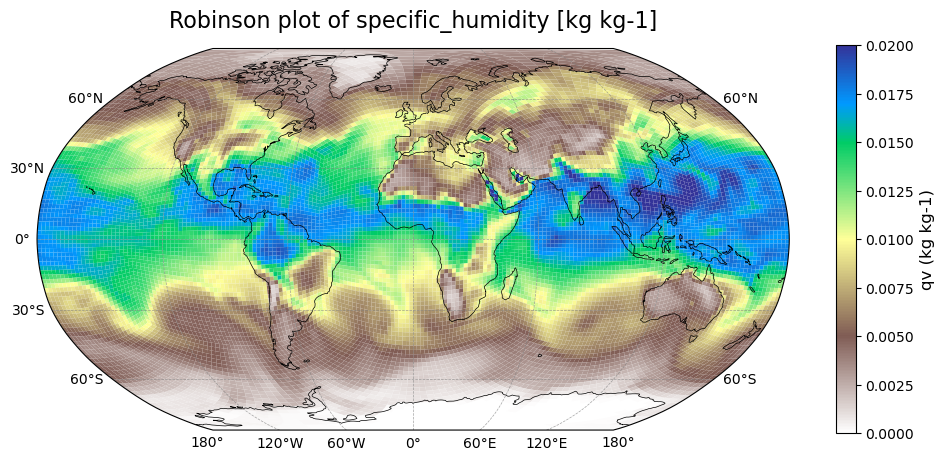

In [13]:
fig = plt.figure(figsize=(10, 10))
proj = ccrs.Robinson(central_longitude=0)
ax = plt.axes(projection=proj)

# using a polycollection for quickly plotting a large number of polygons
poly = PolyCollection(
    new_coords,
    array=np.array(new_data),
    cmap=cmap,
    edgecolors="none",
    transform=ccrs.PlateCarree(),
    clim=[0.0, vmax],
)

ax.add_collection(poly)
ax.coastlines(linewidth=0.5)
ax.set_global()

title = f"Robinson plot of {name} [{units}]"
plt.title(title, fontsize=16, pad=15)

cbar = plt.colorbar(poly, ax=ax, shrink=0.4)
cbar.set_label(f"{variable} ({units})", fontsize=12)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.7,
                  linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}

plt.tight_layout()
plt.show()

## Zoom into specific locations

In [14]:
# user inputs
lon_left = -20
lon_right = 30

lat_min = 40
lat_max = 65


In [15]:
# filter the coords to only plot cells in region
def get_zoom_coords(coords: np.ndarray, data: np.ndarray, lon_min: float,
                    lat_min: float, lon_max: float, lat_max: float,
                    buffer: int = 0) -> tuple[list, list]:
    """
    Function to subset coordinates so that only coords covered by the lat and
    lon inputted + a buffer are returned. Very helpful for plotting.

    Buffer used to prevent certain projections having missing data at plot
    edges.

    Args:
        coords (np.ndarray): face coordinates from the original lfric dataset.
        data (np.ndarray): data values for each face.
        lon_min (float): minimum longitude of the subsetted region.
        lat_min (float): minimum latitude of the subsetted region.
        lon_max (float): minimum longitude of the subsetted region.
        lat_max (float): _description_
        buffer (int, optional): _description_. Defaults to 0.

    Returns:
        tuple[list, list]: coords and data for subsetted region only
    """

    # account for dateline
    lon_min_b = lon_min - buffer
    lon_max_b = lon_max + buffer

    # Case 1: does NOT cross dateline (simple)
    if lon_min_b <= lon_max_b:
        regions = [box(lon_min_b, lat_min - buffer,
                       lon_max_b, lat_max + buffer)]
    else:
        # Case 2: crosses the dateline — make two boxes
        regions = [
            box(lon_min_b, lat_min - buffer, 180, lat_max + buffer),
            box(-180, lat_min - buffer, lon_max_b, lat_max + buffer)
        ]

    zoom_coords = []
    zoom_data = []

    for poly, val in zip(coords, data, strict=True):
        shp = Polygon(poly)
        # Keep if the polygon intersects the region
        if any(shp.intersects(r) for r in regions):
            zoom_coords.append(np.array(shp.exterior.coords))
            zoom_data.append(val)

    return zoom_coords, zoom_data


In [16]:
# hint - you might want to decrease/increase buffer size depending on size of
# area
region_coords, region_data = get_zoom_coords(coords, data, lon_left, lat_min,
                                             lon_right, lat_max, buffer=15)

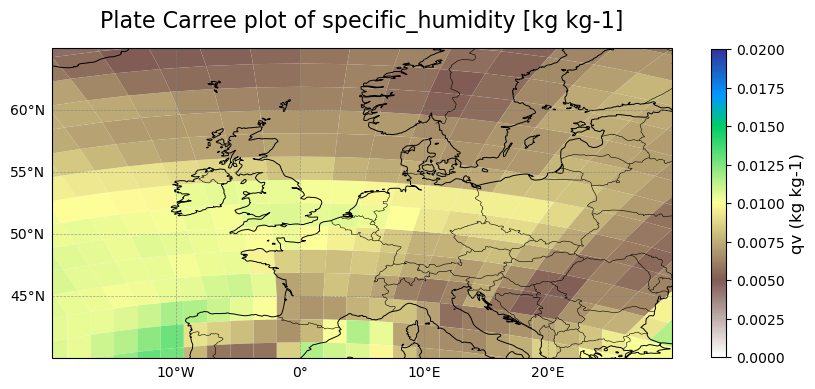

In [17]:
lon1 = (lon_left + 360) % 360
lon2 = (lon_right + 360) % 360
if lon2 < lon1:
    lon2 += 360

fig = plt.figure(figsize=(10, 10))
proj = ccrs.PlateCarree(central_longitude=(lon1 + lon2) / 2)
ax = plt.axes(projection=proj)

# using a polycollection for quickly plotting a large number of polygons
poly = PolyCollection(
    region_coords,
    array=region_data,
    cmap=cmap,
    edgecolors="none",
    transform=ccrs.Geodetic(),
    clim=[0.0, vmax],
)

ax.add_collection(poly)

ax.coastlines(linewidth=0.7, resolution="50m")
ax.add_feature(cfeature.BORDERS, linewidth=0.4)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.7,
                  linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}


ax.set_extent([lon1, lon2, lat_min, lat_max], crs=ccrs.PlateCarree())

title = f"Plate Carree plot of {name} [{units}]"
plt.title(title, fontsize=16, pad=15)

cbar = plt.colorbar(poly, ax=ax, shrink=0.4)
cbar.set_label(f"{variable} ({units})", fontsize=12)

plt.show()

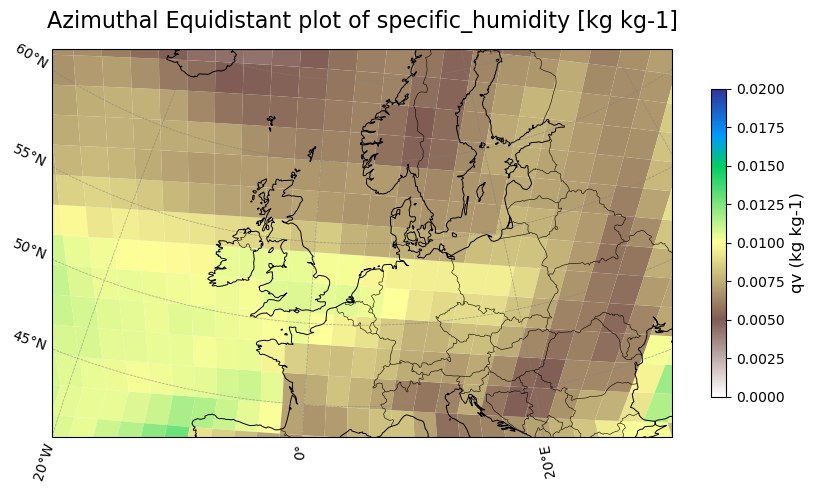

In [18]:
fig = plt.figure(figsize=(10, 10))
proj = ccrs.AzimuthalEquidistant(central_longitude=(lon1 + lon2) / 2,
                                 central_latitude=(lat_min + lat_max) / 2)
ax = plt.axes(projection=proj)

# using a polycollection for quickly plotting a large number of polygons
poly = PolyCollection(
    region_coords,
    array=region_data,
    cmap=cmap,
    edgecolors="none",
    transform=ccrs.Geodetic(),
    clim=[0.0, vmax],
)

ax.add_collection(poly)


ax.coastlines(linewidth=0.7, resolution="50m")
ax.add_feature(cfeature.BORDERS, linewidth=0.4)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.7,
                  linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}


ax.set_extent([lon_left, lon_right, lat_min, lat_max], crs=ccrs.Geodetic())

title = f"Azimuthal Equidistant plot of {name} [{units}]"
plt.title(title, fontsize=16, pad=15)

cbar = plt.colorbar(poly, ax=ax, shrink=0.4)
cbar.set_label(f"{variable} ({units})", fontsize=12)

plt.show()

***Written by Rob Waters, 2025***